# **SeisMIC** Tutorial
In the following, we will go through a simple example to compute a ambient noise correlations and monitor velocity changes using **SeisMIC**.

The main code is hosted here: [SeisMIC](https://github.com/PeterMakus/PyGLImER).

The documentation, which this notebook is based upon is located here:
[SeisMIC Documentation](https://petermakus.github.io/PyGLImER/).

Without further ado, we'll dive right into it starting with data download.

## 1. Download the raw data
**SeisMIC** uses [obspy](https://docs.obspy.org/) to download data from FDSN servers. As an exercise, we will download
data from the station `BP.GHIB` to investigate the coseismic velocity change caused by the 2004 Parkfield earthquake
(see Hadziioannou et. al., 2011).

To download the data, we will use the `seismic.trace_data.waveform.Store_Client` class and its method `download_waveforms_mdl()`.

In [2]:
import os

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from seismic.trace_data.waveform import Store_Client

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

root = os.path.join(ipynb_path, 'data')
os.makedirs(root, exist_ok=True)

starttime = UTCDateTime(year=2004, month=8, day=15)
endtime = UTCDateTime(year=2004, month=10, day=31)
network = 'BP'
station = 'GHIB'


c = Client('NCEDC')
sc = Store_Client(c, root, read_only=False)
sc.download_waveforms_mdl(
    starttime, endtime, clients=[c], network=network,
    station=station, location='*', channel='BP?')


[2021-10-15 15:21:48,143] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://service.ncedc.org.
[2021-10-15 15:21:48,147] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://service.ncedc.org.
[2021-10-15 15:21:48,149] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2021-10-15 15:21:48,150] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://service.ncedc.org' - Requesting unreliable availability.
[2021-10-15 15:21:48,962] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://service.ncedc.org' - Successfully requested availability (0.81 seconds)
[2021-10-15 15:21:48,975] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://service.ncedc.org' - Found 1 stations (3 channels).
[2021-10-15 15:21:48,975] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://service.ncedc.org' - Will attempt to download data from 1 stations.
[2021-10-15 15:21:48,984] - ob

Some notes about this:
1. The method `download_waveforms_mdl()` expects a list of clients as input.
2. All arguments accept wildcards

If everything worked fine. This should have created a folder called `data/mseed` and `data/inventory`. Let's check

In [8]:
os.listdir('./data/')

['inventory', 'mseed']

## 2. Compute Correlations
That seems to have worked, so we are ready to use this raw data to compute ambient noise correlations.

### 2.1 Parameters
Parameters are provided as a `yaml` file or a `dict` object. This tutorial comes with an yaml file to process the data. Let's have a short look at it using bash.

In [3]:
!cat params.yaml

#### Project wide parameters
# lowest level project directory
proj_dir : 'data/'
# directory for logging information
log_subdir : 'log'
# levels:
# 'DEBUG', 'INFO', 'WARNING', 'ERROR', or 'CRITICAL'
log_level: 'INFO'
# folder for figures
fig_subdir : 'figures'
# folder containing preprocessed data


#### parameters that are network specific
net:
    # list of stations used in the project
    # type: list of strings or string, wildcards allowed
    network : 'BP'
    station : 'GHIB'
    # stations : ['D0.BZG', 'D0.ESO', 'D0.KBG', 'D0.KIR']
    # list of channels
    # type: list of strings
    channels : ['BHZ','BHN','BHE']

#### parameters for correlation (emperical Green's function creation)
co:
    # subdirectory of 'proj_dir' to store correlation
    # type: string
    subdir : 'corr'
    # times sequences to read for cliping or muting on stream basis
    # These should be long enough for the reference (e.g. the standard
    # deviation) to be rather independent of the parts to rem

Each of the parameters is described in the [Documentation](url.to.doc.org).

To start the computation of the correlation we will use `MPI` and a simple python script, which could look like this:

In [5]:
!cat correlate.py

from time import time

from obspy.clients.fdsn import Client

from seismic.correlate.correlate import Correlator
from seismic.trace_data.waveform import Store_Client

# Path to the paramter file we created in the step before
params = 'params.yaml'
# You don't have to set this (could be None)
client = Client('IRIS')
# root is the same as proj_dir in params.yaml
root = 'data'
sc = Store_Client(client, root)

c = Correlator(sc, options=params)
print('Correlator initiated')
x = time()
st = c.pxcorr()
print('Correlation finished after', time()-x, 'seconds')

## 2.2 Start correlation
To start the correlation, we will use the `mpirun` command in bash:

In [10]:
import os
# This gives number of threads, usually twice as many as physical cores
ncpus = os.cpu_count()//2
!mpirun -n $ncpus python correlate.py

Correlator initiated
Correlator initiated
Correlator initiated
Correlator initiated
Correlator initiated
Correlator initiated
 29%|██▉       | 23/78 [02:03<04:53,  5.33s/it]2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,840 - INFO - no new data for times 2004-09-07T20:00:01.000000Z-2004-09-08T16:00:01.000000Z
2021-10-15 15:31:41,931 - INFO - no new data for times 2004-09-07T21:00:01.000000Z-2004-09-08T18:00:01.000000Z
2021-10-15 15:31:41,931 - INFO - no new data for t

Now let's have a look at those correlations. To do so, we use the `CorrelationDataBase` object.
All correlations are saved in the folder `data/corr` as defined in our params.yaml file.

In [1]:
from seismic.db.corr_hdf5 import CorrelationDataBase

with CorrelationDataBase('data/corr/BP-BP.GHIB-GHIB.h5', mode='r') as cdb:
    # find the available labels
    print(list(cdb.keys()))

['co', 'stack_86398', 'subdivision']


**SeisMIC's** standard labels are `'subdivision` for the correlations of corr_len and `stack_*stacklen*` for the stack (with *stacklen* being the length of the stack in seconds).

**SeisMIC** uses some sort of "combined seed codes" structured as above.

In [2]:
with CorrelationDataBase('data/corr/BP-BP.GHIB-GHIB.h5', mode='r') as cdb:
    # find the available labels
    print(cdb.get_available_channels(
        tag='stack_86398', network='BP-BP', station='GHIB-GHIB'))
    cst = cdb.get_data('BP-BP', 'GHIB-GHIB', 'BP1-BP2', 'stack_86398')
print(type(cst))

['BP1-BP2', 'BP1-BP3', 'BP2-BP3']
<class 'seismic.correlate.stream.CorrStream'>


`cst` is now a `CorrStream` - an obspy based object to handle correlations. We can plot those in a section plot for example by time:

/home/pm/Documents/SeisMIC/src/seismic/plot/plot_correlation.py:229: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, np.array(y), data)


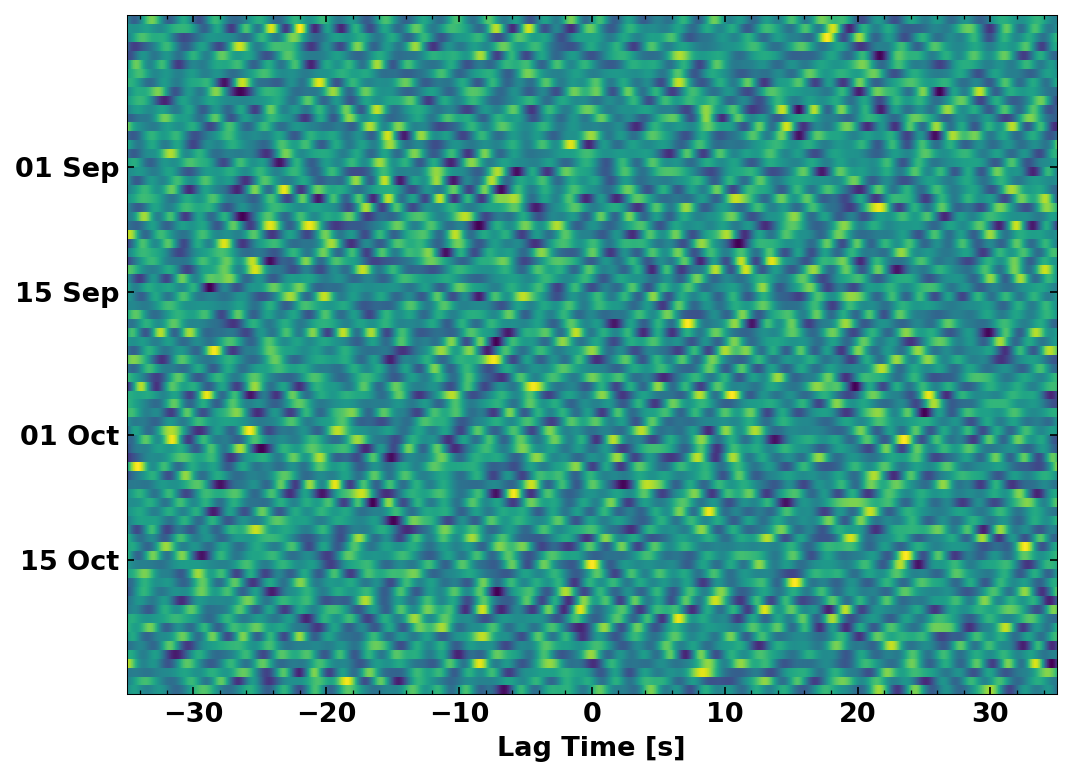

In [8]:
cst.plot(timelimits=[-35, 35])

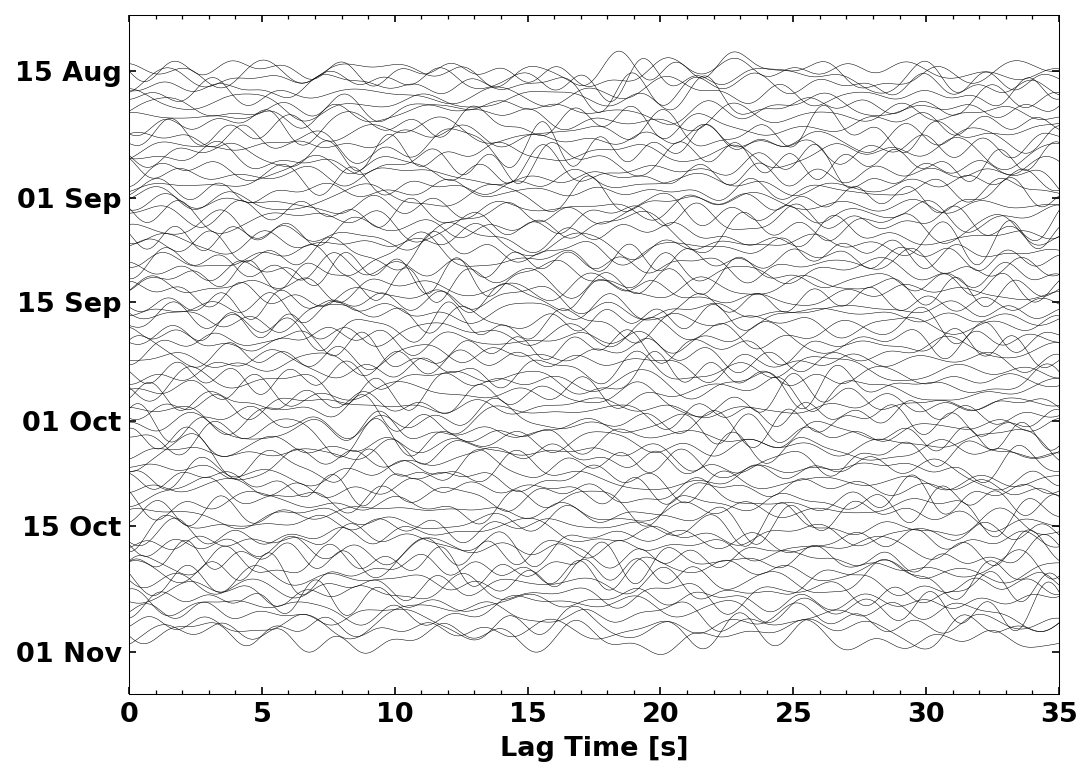

In [9]:
cst.plot(scalingfactor=3, timelimits=[0, 35], type='section')

We can also look at a single correlation:

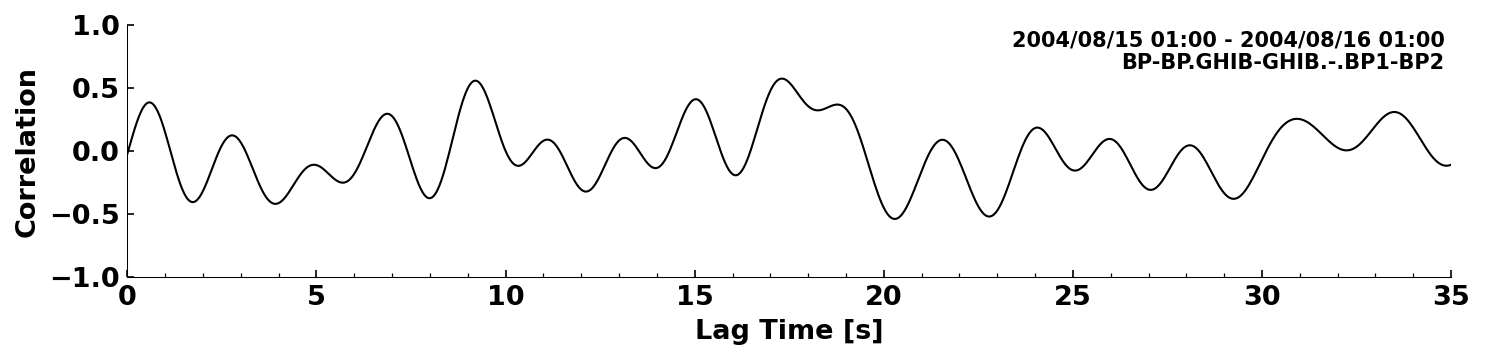

In [ ]:
cst[1].plot(tlim=[0,35])

## 3. Monitoring
Similarly to the Correlation we can start the monitor via a simple script:

In [ ]:
!cat monitor.py

from miic3.monitor.monitor import Monitor

yaml_f = 'params.yaml'
m = Monitor(yaml_f)
m.compute_velocity_change_bulk()


In [ ]:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

!mpirun -n $ncpus python ./monitor.py

./monitor.py: 1: from: not found
./monitor.py: 3: yaml_f: not found
./monitor.py: 4: Syntax error: "(" unexpected


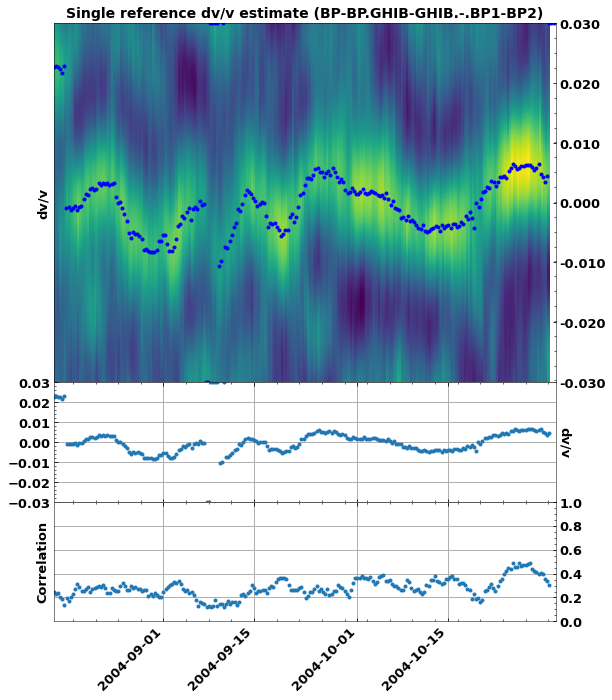

In [ ]:
from seismic.monitor.dv import read_dv
dv = read_dv('data/vel_change/DV-BP-BP.GHIB-GHIB.BP1-BP2.npz')
dv.plot()

Even with comparably little data, we can see the velocity drop. Note that we had to
take fairly long time windows (especially given the quite long periods).